# Домашняя работа

-------------------------------------------------------

# Import libs

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
sys.path.append(os.path.abspath('../src/'))

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

In [70]:
import requests

tg_api_token = '5043397400:AAExpKcTarTWA2nYlvB_rOyL7vMVe8e1DFw'
tg_chat_id = '1971178318'

def send_tg_message(text='Cell execution completed.'):
    requests.post(
        'https://api.telegram.org/' +
        'bot{}/sendMessage'.format(tg_api_token), 
        params=dict(chat_id=tg_chat_id, text=text)
    )

## Read data

In [71]:
from pathlib import Path

DATA_PATH = Path('../Data/')
RETAIL_TRAIN_PATH = DATA_PATH / 'retail_train.csv'
ITEM_FEATURE_PATH = DATA_PATH / 'product.csv'
USER_FEATURE_PATH = DATA_PATH / 'hh_demographic.csv'

data = pd.read_csv(RETAIL_TRAIN_PATH)
item_features = pd.read_csv(ITEM_FEATURE_PATH)
user_features = pd.read_csv(USER_FEATURE_PATH)


# Process features dataset

In [72]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Split dataset for train, eval, test

In [73]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [74]:
# данные со старых покупок до 9 недельной давности. Тренировка для модели первого уровня
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# данные от 9 недельной давности до 3 недельной давности. Тест для модели первого уровня
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели (не более 3 недельной давности)
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [75]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [76]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


# Prefilter items

**TODO**: подобрать другие числа для take_n_popular

In [77]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, 
                                     items_data=item_features, 
                                     take_n_popular=5000,
                                     warm_start=True
                                    )

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5000


# Make cold-start to warm-start

**TODO**: make cold-start

In [78]:
# ищем общих пользователей
common_users = list(set(data_train_matcher.user_id.values)&(set(data_val_matcher.user_id.values))&set(data_val_ranker.user_id.values))

# warm-start: оставляем только тех пользователей которые есть во всех трех наборах данных
data_train_matcher = data_train_matcher[data_train_matcher.user_id.isin(common_users)]
data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (1013530, 13) Users: 1904 Items: 5000
val_matcher
Shape: (162611, 12) Users: 1904 Items: 26640
train_ranker
Shape: (162611, 12) Users: 1904 Items: 26640
val_ranker
Shape: (115539, 12) Users: 1904 Items: 23734


# Init/train recommender

**#TODO**: попробовать другие модели LinearRegression, LightFM

In [79]:
# ALS
recommender = MainRecommender(data_train_matcher, item_features=item_features, warm_start=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

# Get candidates

**Задание 1.**

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [80]:
# result_eval_matcher.to_csv('../Data/result_eval_matcher.csv')
# data_train_matcher.to_csv('../Data/data_train_matcher.csv')

In [81]:
import swifter


def fit_first_level_model(recommender: MainRecommender, 
                          user_id_df: pd.DataFrame, 
                          user_column_name: str,
                          n_predicts: int, 
                          model_name: str):
    """
    Return fitted model, witch name is getted in `model_name` parametr. 
    `model_name` can to get one of this values - ['own_rec', 'sim_item_rec', 'als_rec', 'sim_user_rec_var_1', 'sim_user_rec_var_2']
    If model_name is None, it will calculate total tables with all avoid values
    """
    
    if not model_name:
        # для понятности расписано все в строчку, без функций, ваша задача уметь оборачивать все это в функции
        user_id_df['own_rec'] = user_id_df[user_column_name].swifter.apply(lambda x: recommender.get_own_recommendations(x, N=n_predicts))
        user_id_df['sim_item_rec'] = user_id_df[user_column_name].swifter.apply(lambda x: recommender.get_similar_items_recommendation(x, n=n_predicts))
        user_id_df['als_rec'] = user_id_df[user_column_name].swifter.apply(lambda x: recommender.get_als_recommendations(x, N=n_predicts))

        user_id_df['sim_user_rec_var_1'] = user_id_df[user_column_name].swifter.apply(
            lambda x: recommender.get_similar_users_recommendation(x, N=n_predicts, option=1)
        )

        user_id_df['sim_user_rec_var_2'] = user_id_df[user_column_name].swifter.apply(
            lambda x: recommender.get_similar_users_recommendation(x, N=n_predicts, option=2)
        )
        
        return user_id_df
    
    if model_name == 'sim_user_rec_var_2':
        return user_id_df[user_column_name].swifter.apply(
            lambda x: recommender.get_similar_users_recommendation(x, N=n_predicts, option=2)
        )
    
    if model_name == 'sim_user_rec_var_1':
        return user_id_df[user_column_name].swifter.apply(
            lambda x: recommender.get_similar_users_recommendation(x, N=n_predicts, option=1)
        )
    
    
    if model_name == 'own_rec':
        return user_id_df[user_column_name].swifter.apply(lambda x: recommender.own_recommender(x, N=n_predicts))
    
    if model_name == 'sim_item_rec':
        return user_id_df[user_column_name].swifter.apply(lambda x: recommender.get_similar_items_recommendation(x, N=n_predicts))
    
    if model_name == 'als_rec':
        return user_id_df[user_column_name].swifter.apply(lambda x: recommender.get_als_recommendations(x, N=n_predicts))
    
    




In [82]:
ACTUAL_COL = 'actual'

def get_validation_data_frame(data_val):
    result_eval_matcher = data_val.groupby(USER_COL)[ITEM_COL].unique().reset_index()
    result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
    return result_eval_matcher
    
    
get_validation_data_frame(data_val_matcher).head(2)



,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."


### A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

In [83]:
N_PREDICT = 50 

result_eval_matcher = get_validation_data_frame(data_val_matcher).head(2)

fit_first_level_model(
    recommender=recommender,
    user_id_df=result_eval_matcher,
    user_column_name=USER_COL,
    n_predicts=N_PREDICT,
    model_name=None
)

send_tg_message('Calc is done')

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

In [84]:
result_eval_matcher.head(2)

,user_id,actual,own_rec,sim_item_rec,als_rec,sim_user_rec_var_1,sim_user_rec_var_2
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 9655212, 8293439, 1...","[1035805, 8119097, 9526410, 1007512, 9297615, ...","[9296957, 1082212, 885290, 918907, 958046, 856...","[962229, 898847, 995242, 1070820, 1070015, 112...","[962229, 862349, 1070820, 1092937, 995242, 983..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[13003092, 1041259, 995598, 1084036, 5569792, ...","[866211, 825541, 904360, 948650, 845208, 70252...","[1082185, 1024306, 878996, 857006, 854852, 105...","[1127831, 945652, 5569230, 1026118, 1041796, 1...","[1127831, 8090440, 1024306, 1082185, 1106523, ..."


In [85]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [86]:
sorted(calc_recall(result_eval_matcher, N_PREDICT), key=lambda x: x[1],reverse=True)

[('own_rec', 0.11136917895714785),
 ('als_rec', 0.10567878295203809),
 ('sim_item_rec', 0.09650447102543258),
 ('sim_user_rec_var_1', 0.04366507954941354),
 ('sim_user_rec_var_2', 0.04081988154685867)]

Из данных приведенных выше видно, что наибольшее значение recall получили модель own_rec

### Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}

In [87]:
n_predicts = [20, 50, 100, 200, 500]
selected_model_name = 'als_rec'   # выбираем наибольший recall, за исключением own, т.к рекомендации такого рода бесполезны
result_eval_matcher = get_validation_data_frame(data_val_matcher)

result_eval_matcher[selected_model_name] = fit_first_level_model(
    recommender=recommender,
    user_id_df=result_eval_matcher,
    user_column_name=USER_COL,
    n_predicts=n_predicts[-1],
    model_name=selected_model_name,
)

result_eval_matcher.head(2)

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

,user_id,actual,als_rec
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[9296957, 1082212, 885290, 918907, 958046, 856..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[1082185, 1024306, 878996, 857006, 854852, 105..."


In [88]:
recall_at_list = [round(list(calc_recall(result_eval_matcher, n_predict))[0][1], 5) for n_predict in n_predicts]
recall_at_list

[0.03997, 0.07035, 0.10494, 0.15294, 0.23431]

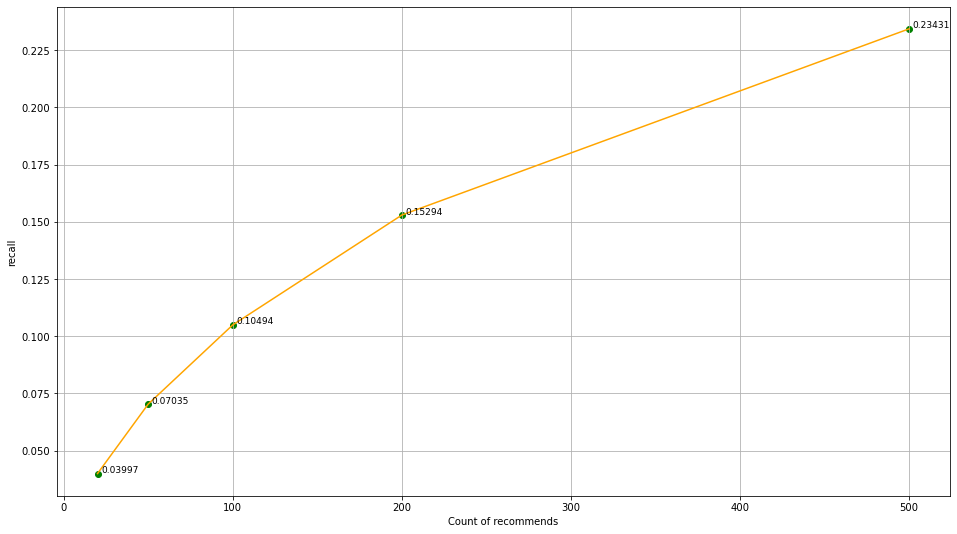

In [89]:
plt.figure(figsize=(16, 9))
plt.plot(n_predicts, recall_at_list, c='orange')
plt.scatter(n_predicts, recall_at_list, c='green')

[plt.text(n_predicts[i] + 2, recall_at_list[i] + .0005, txt, fontsize=9) for i, txt in enumerate(recall_at_list)]

plt.grid()

plt.xlabel('Count of recommends')
plt.ylabel('recall')
plt.show()

Видно, что зависимость логарифмическая

### C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

Из графика выше видно, что чем больше число рекомендаций, тем выше recall. Баланс между скоростью алгоритма, числом рекомендаций и производительностью оборудования которое нам доступно, является определяющим фактором для выбора числа рекомендаций. 

**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

Подготовка данных для трейна

In [93]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]
df_match_candidates

,user_id
0,2070
1,2021
2,1753
3,1346
4,2324
...,...
1899,1446
1900,1784
1901,436
1902,1697


In [94]:
# собираем кандитатов с первого этапа (matcher)
N_PREDICT=200

df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1085604, 1107553, 1082185, 908531, 1029743, 8..."
1,2021,"[12731544, 951590, 1009333, 846823, 981760, 10..."


In [95]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)
df_match_candidates.head(8)

,user_id,item_id
0,2070,1085604
0,2070,1107553
0,2070,1082185
0,2070,908531
0,2070,1029743
0,2070,879755
0,2070,834103
0,2070,9526410


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1

In [96]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

df_ranker_train['target'].fillna(0, inplace= True)

In [97]:
df_ranker_train

,user_id,item_id,target
0,2070,1085604,1.0
1,2070,1107553,0.0
2,2070,1082185,1.0
3,2070,908531,1.0
4,2070,1029743,0.0
...,...,...,...
390161,1745,1063707,0.0
390162,1745,1099905,0.0
390163,1745,5563934,0.0
390164,1745,899844,0.0


## Подготавливаем фичи для обучения модели

***A) Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар***

**Фичи user_id:**
   - Средний чек
   - Средняя сумма покупки 1 товара в каждой категории
   - Кол-во покупок в каждой категории
   - Частотность покупок раз/месяц
   - Долю покупок в выходные
   - Долю покупок утром/днем/вечером

**Фичи item_id**:
   - Кол-во покупок в неделю (как часто покупают этот товар)
   - Среднее ол-во покупок 1 товара в категории в неделю (насколько востребована категория)
   - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю) - процент востребованости этого товара в данной категории
   - Цена (Можно посчитать из retil_train.csv)
   - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
   - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
   - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
   - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [98]:
sv_user_features = user_features.copy()
sv_item_features = item_features.copy()

In [99]:
from feature_generation import *


additional_user_features = make_pipeline(
    AddPriceColumn(),
    AverageCheck(),
    AveragePriceCounItemADepartment(items_department=item_features[['item_id', 'department']]),
    PurchasesAMonth(),
    DropColumn(column_name='price'),
    UpdateFeaturesTable(feature_table=user_features,
                        X_old_columns_names=data_train_ranker.columns,
                        merge_on=['user_id'])
)

user_features = additional_user_features.fit_transform(data_train_ranker)

additional_items_features = make_pipeline(
    AddPriceColumn(),
    PurchasesCountAWeek(),
    AveragePurchasesCountADepartment(item_department_table=item_features[['item_id', 'department']]),
    LikePercentADepartment(),
    HigherThenMedianPricePercent(),
    UpdateFeaturesTable(feature_table=item_features,
                        X_old_columns_names=data_train_ranker.columns,
                        merge_on='item_id')
)

item_features = additional_items_features.fit_transform(X=data_train_ranker)

In [102]:
item_features.dtypes

item_id                               int64
manufacturer                          int64
department                           object
brand                                object
commodity_desc                       object
sub_commodity_desc                   object
curr_size_of_product                 object
avg_price_a_department              float64
higher_then_median_price_percent    float64
popular_items_a_week                float64
like_percent_a_department           float64
popular_department                  float64
avg_quantity_week                   float64
dtype: object

In [103]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

In [106]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [109]:
# from utils import reduce_mem_usage

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

reduce_mem_usage(X_train)

In [118]:
cat_features = X_train.dtypes[X_train.dtypes == 'category'].index.tolist()
cat_features

['department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

**#TODO**: Select best models in LGBMClassifier and Catboost

**#TODO**: improve models

In [120]:
%%time

lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

C:\ProgramData\Anaconda3_\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3_\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Wall time: 11.4 s


In [132]:
df_ranker_predict = df_ranker_train.copy()

In [133]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [134]:
df_ranker_predict.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,avg_price_a_department,...,GROCERY_price,MEAT_count,AUTOMOTIVE_count,CNTRL/STORE SUP_price,AUTOMOTIVE_price,MEAT-PCKGD_count,VIDEO_count,FROZEN GROCERY_price,MISC. TRANS._price,proba_item_purchase
0,2070,1085604,1.0,103,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,2.102374,...,1.628849,8.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.603835
1,2070,1107553,0.0,103,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,2.102374,...,1.628849,8.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.491685
2,2070,1082185,1.0,2,PRODUCE,National,TROPICAL FRUIT,BANANAS,40 LB,2.075872,...,1.628849,8.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.870801
3,2070,908531,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,CHOCOLATE MILK,,2.102374,...,1.628849,8.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.304932
4,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,2.102374,...,1.628849,8.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.755096


# Evaluation on test dataset

In [124]:
precision_at_k_matching

0.16943277310924182

In [125]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


## Eval matching on test dataset

In [127]:
N_PREDICT = 5

In [128]:
%%time
result_eval_ranker['als_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))

Wall time: 11.3 s


In [129]:
sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('als_rec', 0.14474789915966274)]

## Eval re-ranked matched result on test dataset

In [130]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [135]:
result_eval_ranker['reranked_als_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [136]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_als_rec', 0.18939075630251753)
('als_rec', 0.14474789915966274)
